In [72]:
import tensorflow as tf

import gc

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np  
import h5py

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras import models

from keras import layers
from keras.models import Sequential

from keras.losses import SparseCategoricalCrossentropy

import os
import re

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from IPython.display import HTML, display

In [ ]:
data_path = "/content/drive/MyDrive/Master_AI/DL/Assingments2022/A3/Data_Ass3/" #@param {type:"string"}
model_path = "/content/drive/MyDrive/Master_AI/DL/Assingments2022/A3/Models/" #@param {type:"string"}

sample_window_size = 248 #@param [248, 596, 744]

classification_type = "Intra" #@param ["Intra", "Cross"]
trainOtest = "train" #@param ["train", "test"]
task_type = "rest" #@param ["rest", "task_motor", "task_story_math", "task_working_memory"]

In [ ]:

import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))

In [74]:
class DatasetGenerator:

  base_path = "/content/drive/MyDrive/Master_AI/DL/Assingments2022/A3/Data_Ass3/"
  folder_paths = [["Intra/train/","Intra/test/"],["Cross/train/","Cross/test1/","Cross/test2/","Cross/test3/"]]
  label_names = ['rest','task_motor','task_story_math','task_working_memory']
  label_dict = {'rest' : [1,0,0,0], 'task_motor' : [0,1,0,0], 'task_story_math' : [0,0,1,0], 'task_working_memory' : [0,0,0,1]}
  
  #file_paths = None
  #patient_numbers = None

  sample_window_size = 248

  def __init__(self, base_path = "/content/drive/MyDrive/Master_AI/DL/Assingments2022/A3/Data_Ass3/", sample_window_size = 248):
    self.base_path = base_path
    self.sample_window_size = sample_window_size

  def progress(self, value, max=100):
    return HTML("""<progress value='{value}' max='{max}', style='width: 100%' > {value} </progress> """.format(value=value, max=max))


  def build_folder_path(self,isCross = 0, testFolder = 0):
    path = self.base_path + self.folder_paths[isCross][testFolder]
    return path

  def load_filelist(self,isCross = 0, testFolder = 0):
    self.file_paths = os.listdir(self.build_folder_path(isCross,testFolder)) 
    self.file_paths.sort()

  def filtered_filelist(self ,file_list = None, keywords=['rest']):
    if not file_list:
      file_list = self.file_paths
    for keyword in keywords:
      r = re.compile(keyword)
      filtered_list = list(filter(r.match, file_list))
    return filtered_list

  def collect_patient_numbers(self):
    patient_numbers = []
    for file_path in self.file_paths:
      patient_numbers.append(re.search(r"\d{6}",file_path).group(0))
    patient_numbers = list (dict.fromkeys(self.patient_numbers))
    return patient_numbers

  def get_dataset_name(self,file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

  def load_file(self,path):
    with h5py.File(path,'r') as f:
      dataset_name = self.get_dataset_name(path)
      data = f.get(dataset_name)[()]
      return data

  def load_task_block(self,isCross = 0, testFolder = 0, filter=['rest']):
    filtered_list = self.filtered_filelist(self.file_paths,filter)
    dataset = np.zeros((248, 1))
    for file_path in filtered_list:
      filename_path = self.build_folder_path(isCross,testFolder) + file_path
      matrix = self.load_file(filename_path)
      dataset = np.concatenate((dataset, matrix), axis=1)
      gc.collect()
    dataset = np.delete(dataset,0, axis=1)
    return dataset

  def norm_data(self,dataset):
    normed_data = dataset*1.0
    scale_table = np.zeros((2,248))
    for i in range(248):
      scale_table[0,i] = normed_data[i,:].min()
      scale_table[1,i] = normed_data[i,:].max()
    scale_table[1] = scale_table[1] - scale_table[0]
    for i in range(248):
      normed_data[i,:] = (normed_data[i,:] - scale_table[0,i])/scale_table[1,i]
    return normed_data

  def smooth_data(self,data,window=10):
    smooth_data = data*1.0
    for i in range(248):
      smooth_data[i,:] = pd.Series(smooth_data[i,:]).rolling(window = window).mean()
    return data

  def drop_frames(self,data,droprate = [2,2,2], offset = [0,0,0]):
    for i in range(len(droprate)):
      data = np.delete(data, list(range(offset[i], data.shape[1], droprate[i])), axis=1)
    return data

  def resample_dataset(self,data,lable,sample_window = [170,248,0]):
    dataset = self.drop_frames(data,[2,2,2])
    #dataset = self.smooth_data(dataset)
    dataset = self.norm_data(dataset)
    dataset = dataset.reshape((248,dataset.shape[1],1))
    smp_overhang = int (sample_window[1] / sample_window[0])
    sample_amount = int ((dataset.shape[1]-sample_window[2]) / sample_window[0]) - smp_overhang
    train_X = np.zeros(shape=(sample_amount,248,sample_window[1],1))
    for i in range(sample_amount):
      sp = (i*sample_window[0]) + sample_window[2]
      ep = sp+sample_window[1]
      train_X[i] = dataset[:,sp:ep,:]
    train_y = lable*train_X.shape[0]
    train_y = np.array(train_y).reshape((train_X.shape[0],4))
    gc.collect()
    return train_X, train_y

  def create_DataSet(self,sample = [0,0], sample_window = [170,248,0]):
    #window_size = 744#496
    self.out = display(self.progress(0, 100), display_id=True)
    self.out.update(self.progress(1, 100))
    train_X =  np.zeros((1, 248, sample_window[1], 1))
    train_y =  np.zeros((1, 4))
    self.load_filelist(sample[0],sample[1])
    for i in range(4):
      itr_progerss = int (80/(4-i))
      self.out.update(self.progress(itr_progerss, 100))
      print('Block ['+ self.label_names[i], end=']: ')
      dataset = self.load_task_block(isCross=sample[0],testFolder=sample[1],filter=[self.label_names[i]])
      print('-', end=' ')
      self.out.update(self.progress(itr_progerss+5, 100))
      new_X,new_y = self.resample_dataset(dataset,self.label_dict[self.label_names[i]],sample_window)
      print('-', end=' ')
      self.out.update(self.progress(itr_progerss+10, 100))
      train_X = np.concatenate((train_X, new_X), axis=0)
      train_y = np.concatenate((train_y, new_y), axis=0)
      print('- Finished')
    train_X = np.delete(train_X,0, axis=0)
    train_y = np.delete(train_y,0, axis=0)
    gc.collect()
    print('Shape:' + str(train_X.shape))
    return train_X,train_y

  def create_trainDataSet(self, sample_window = [170,248,0], isCross = 0, batch_size = 32, validation_split = 0.2, seed = 1000):
    print('Create Train Dataset:')
    data_folder = [isCross,0]
    train_X,train_y = self.create_DataSet(sample=data_folder,sample_window = sample_window)
    train_set = tf.data.Dataset.from_tensor_slices((train_X,train_y)).shuffle(seed)
    n_validation_split = int(train_X.shape[0] * validation_split)
    val_set = train_set.take(n_validation_split).batch(batch_size)
    trn_set = train_set.skip(n_validation_split).batch(batch_size)
    self.out.update(self.progress(99, 100))
    gc.collect()
    self.out.update(self.progress(100, 100))
    return trn_set, val_set

  def create_testDataSet(self, isCross = 0,test_sample = 1, sample_window=[170,248,0]):
    print('Create Test Dataset:')
    data_folder = [isCross,test_sample]
    
    test_X, test_y = self.create_DataSet(sample=data_folder,sample_window=sample_window)
    self.out.update(self.progress(99, 100))
    gc.collect()
    self.out.update(self.progress(100, 100))
    return test_X, test_y

#ds_Gen = DatasetGenerator()
#trn_set, val_set = ds_Gen.create_trainDataSet([170,248,1000])
#print(trn_set)

In [76]:
class ModelGenerator:

  model = None
  history = None

  def __init__(self, name, input_shape,autobuild=True,compile=True,batch_norm = False):
    self.name = name
    self.input_shape = input_shape

    self.model = Sequential()
    self.history = []

    if(autobuild):
      self.setup_input_layer()
      self.Conv_layer_block(dropout = False,batch_norm = False)
      self.output_layer_block()
    if(compile):
      self.compile_model()

  def getModel(self):
    return

  def compile_model(self,loss='mse'):
    self.model.compile(
                optimizer=tf.optimizers.Adam(),loss = loss ,#loss="categorical_crossentropy",#loss='mse',#loss='mse',
                 metrics=['accuracy'])
                #metrics=['mse'])#,tf.keras.metrics.RootMeanSquaredError(),'mae'])
    #self.nn_model.compile(optimizer='adam', loss='mse')
    return 

  def fit(self,train,validation,patience=2,MAX_EPOCHS=25,verbose=1, early_stopping_mode = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=patience, restore_best_weights = True,
                                                    mode='max')
    if(early_stopping_mode == 1):
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience, restore_best_weights = True,
                                                    mode='min')

    return self.model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validation,verbose=verbose,
                      callbacks=[early_stopping])
    
    #self.history = self.trained_model.history

    return self.history

  def summary(self): self.model.summary()

  def setup_input_layer(self):
    self.model.add(layers.InputLayer(input_shape=self.input_shape))
    return

  def Conv_layer_block(self,batch_norm = False,dropout = False):
    self.model.add(layers.Conv2D(filters=16, kernel_size=(24,24),strides=4, activation='relu'))
    if(dropout): self.model.add(tf.keras.layers.Dropout(rate=0.1))
    if(batch_norm): self.model.add(tf.keras.layers.BatchNormalization())
    #self.model.add(layers.MaxPooling2D(pool_size=(1,2)))
    self.model.add(layers.Conv2D(filters=32, kernel_size=(16,16),strides=2, activation='relu'))
    self.model.add(layers.MaxPooling2D(pool_size=(2,2)))
    if(batch_norm): self.model.add(tf.keras.layers.BatchNormalization())
    #self.model.add(tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))

    if(dropout): self.model.add(tf.keras.layers.Dropout(rate=0.1))
    self.model.add(layers.Conv2D(filters=64, kernel_size=(8,8),strides=1, activation='relu'))
    self.model.add(layers.MaxPooling2D(pool_size=(2,2)))
    if(batch_norm): self.model.add(tf.keras.layers.BatchNormalization())
    return

  def output_layer_block(self,layer_sizes=[128,64,16]):
    self.model.add(layers.Flatten())
    for layerS in layer_sizes:
      self.model.add(layers.Dense(layerS,activation='relu'))
    self.model.add(layers.Dense(units=4, activation='softmax'))
    return

  def saveModel(self,path):
    self.model.save(path)
    return
  def loadModel(self,path):
    self.model = tf.keras.models.load_model(path)
    return

#meg_classifier = ModelGenerator("Classifier J", (248, 248, 1))
#meg_classifier = ModelGenerator("Classifier J", (248, 496, 1))
#meg_classifier = ModelGenerator("Classifier J", (248, 744, 1))
#meg_classifier.summary()

In [4]:
def train_model(model, epochs=[10,15,25], patience=[3,5,7], data_source = [0,0,0], data_offset = [0,60,120],data_betweensample_offset = [170,170,170] ,data_sample_size = 248):
  super_epochs = len(epochs)
  dsGenerator = DatasetGenerator()

  for training_cycle in range(super_epochs):
    print('Start Cycle ' + str(training_cycle))
    #Create Dataset
    trn_set, val_set = dsGenerator.create_trainDataSet([data_betweensample_offset[training_cycle] ,data_sample_size, data_offset[training_cycle]], data_source[training_cycle])
    gc.collect()
    #Train Model on data set
    history = meg_classifier.fit(trn_set,val_set,patience[training_cycle],epochs[training_cycle]) #TODO changes needed
    #Save Model
    gc.collect()

  return history
  
def visulize_model_performance(model):
  # 6 plots [accuracy graph; loss graph; intra test hm; cross test1 hm; cross test2 hm; cross test3 hm]
  return accuracy

def do_model(model_name = 'MEG_Classifier', model_path = None, epochs=[10,15,25], patience=[3,5,7], data_source = [0,0,0], data_offset = [0,60,120]):
  if model_path:
    print('Load Model')
    #Load Model from given path
  else:
    print('Build Model')
    
    train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset)

  #Evaluate / Visiolize Results on Test samples

Start Cycle 0
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1672, 248, 248, 1)
Epoch 1/10
50/50 [==============================] - 49s 954ms/step - loss: 0.2162 - accuracy: 0.2494 - val_loss: 0.1891 - val_accuracy: 0.1800
Epoch 2/10
50/50 [==============================] - 49s 974ms/step - loss: 0.2052 - accuracy: 0.2576 - val_loss: 0.1680 - val_accuracy: 0.6400
Epoch 3/10
50/50 [==============================] - 49s 981ms/step - loss: 0.1547 - accuracy: 0.5719 - val_loss: 0.0740 - val_accuracy: 0.8300
Epoch 4/10
50/50 [==============================] - 48s 954ms/step - loss: 0.0495 - accuracy: 0.9135 - val_loss: 0.0261 - val_accuracy: 0.9500
Epoch 5/10
50/50 [==============================] - 48s 957ms/step - loss: 0.0162 - accuracy: 0.9790 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 48s 955ms/step - loss: 0.0067 - accuracy: 0.9930 - val_loss

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/15
49/49 [==============================] - 49s 999ms/step - loss: 0.0071 - accuracy: 0.9936 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 2/15
49/49 [==============================] - 48s 987ms/step - loss: 0.0041 - accuracy: 0.9955 - val_loss: 9.3103e-04 - val_accuracy: 1.0000
Epoch 3/15
49/49 [==============================] - 48s 986ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/15
49/49 [==============================] - 49s 989ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/15
49/49 [==============================] - 48s 986ms/step - loss: 7.6417e-04 - accuracy: 1.0000 - val_loss: 5.0063e-04 - val_accuracy: 1.0000
Epoch 6/15
49/49 [==============================] - 49s 990ms/step - loss: 5.5453e-04 - accuracy: 1

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/25
49/49 [==============================] - 51s 1s/step - loss: 0.0042 - accuracy: 0.9949 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2/25
49/49 [==============================] - 51s 1s/step - loss: 0.0038 - accuracy: 0.9974 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 3/25
49/49 [==============================] - 52s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.6862e-04 - val_accuracy: 1.0000
Epoch 4/25
49/49 [==============================] - 51s 1s/step - loss: 9.1535e-04 - accuracy: 1.0000 - val_loss: 6.5512e-04 - val_accuracy: 1.0000
Epoch 5/25
49/49 [==============================] - 51s 1s/step - loss: 7.1039e-04 - accuracy: 1.0000 - val_loss: 4.6523e-04 - val_accuracy: 1.0000
Epoch 6/25
49/49 [==============================] - 51s 1s/step - loss: 5.8838e-04 - accuracy: 1.0000 - va

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)


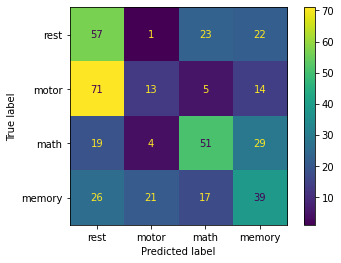

In [6]:
### MEG_Classifier_intra ###
## Define Parameters
data_source = [0,0,0]
data_offset = [0,60,120]
epochs=[10,15,25]
patience=[3,5,7]
model_name = 'MEG_Classifier_intra'

## Build Model
meg_classifier = ModelGenerator(model_name, (248, 248, 1))

## Train Model
history = train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset)

## Test Model

ds_Gen2 = DatasetGenerator()
test_X, test_y = ds_Gen2.create_testDataSet()

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()


Start Cycle 0
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1672, 248, 248, 1)
Epoch 1/25
50/50 [==============================] - 49s 964ms/step - loss: 0.1825 - accuracy: 0.2475 - val_loss: 0.1343 - val_accuracy: 0.3300
Epoch 2/25
50/50 [==============================] - 48s 964ms/step - loss: 0.1369 - accuracy: 0.5299 - val_loss: 0.1001 - val_accuracy: 0.6800
Epoch 3/25
50/50 [==============================] - 48s 963ms/step - loss: 0.0197 - accuracy: 0.9447 - val_loss: 0.0170 - val_accuracy: 0.9600
Epoch 4/25
50/50 [==============================] - 48s 963ms/step - loss: 0.0077 - accuracy: 0.9809 - val_loss: 5.4543e-04 - val_accuracy: 1.0000
Epoch 5/25
50/50 [==============================] - 48s 964ms/step - loss: 0.0013 - accuracy: 0.9955 - val_loss: 0.0035 - val_accuracy: 0.9900
Epoch 6/25
50/50 [==============================] - 48s 963ms/step - loss: 6.6603e-04 - accuracy: 0.9981 - 

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/25
49/49 [==============================] - 48s 986ms/step - loss: 0.0070 - accuracy: 0.9834 - val_loss: 0.0889 - val_accuracy: 0.8200
Epoch 2/25
49/49 [==============================] - 48s 987ms/step - loss: 0.0149 - accuracy: 0.9630 - val_loss: 0.0049 - val_accuracy: 0.9900
Epoch 3/25
49/49 [==============================] - 49s 988ms/step - loss: 0.0046 - accuracy: 0.9892 - val_loss: 2.6108e-05 - val_accuracy: 1.0000
Epoch 4/25
49/49 [==============================] - 49s 990ms/step - loss: 7.6737e-04 - accuracy: 0.9987 - val_loss: 6.4976e-07 - val_accuracy: 1.0000
Epoch 5/25
49/49 [==============================] - 48s 986ms/step - loss: 6.5190e-05 - accuracy: 1.0000 - val_loss: 9.5724e-08 - val_accuracy: 1.0000
Epoch 6/25
49/49 [==============================] - 48s 987ms/step - loss: 3.8189e-06 - acc

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/25
49/49 [==============================] - 49s 993ms/step - loss: 0.0018 - accuracy: 0.9949 - val_loss: 0.0177 - val_accuracy: 0.9500
Epoch 2/25
49/49 [==============================] - 49s 989ms/step - loss: 5.2506e-04 - accuracy: 0.9994 - val_loss: 7.7764e-08 - val_accuracy: 1.0000
Epoch 3/25
49/49 [==============================] - 49s 993ms/step - loss: 2.4520e-04 - accuracy: 0.9994 - val_loss: 2.2916e-07 - val_accuracy: 1.0000
Epoch 4/25
49/49 [==============================] - 49s 991ms/step - loss: 3.6665e-04 - accuracy: 0.9987 - val_loss: 9.3631e-05 - val_accuracy: 1.0000
Epoch 5/25
49/49 [==============================] - 48s 987ms/step - loss: 7.0492e-04 - accuracy: 0.9981 - val_loss: 1.9795e-06 - val_accuracy: 1.0000
Epoch 6/25
49/49 [==============================] - 49s 992ms/step - loss: 2.79

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)


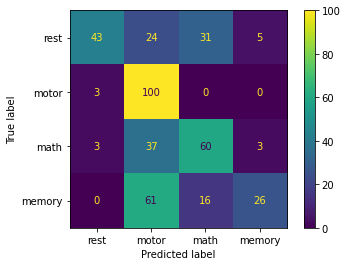

In [21]:
### MEG_Classifier_intra ###
## Define Parameters
data_source = [0,0,0]
data_offset = [0,60,120]
epochs=[25,25,25]
patience=[7,3,3]
model_name = 'MEG_Classifier_intra'

## Build Model
meg_classifier = ModelGenerator(model_name, (248, 248, 1))

## Train Model
history = train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset)
print(history)

## Test Model

ds_Gen2 = DatasetGenerator()
test_X, test_y = ds_Gen2.create_testDataSet()

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

In [ ]:
def cleanup():
  del meg_classifier
  del test_X, test_y
  del ds_Gen2
  gc.collect()

Start Cycle 0
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1672, 248, 248, 1)
Epoch 1/25
21/21 [==============================] - 2s 80ms/step - loss: 0.1878 - accuracy: 0.2960 - val_loss: 0.1941 - val_accuracy: 0.0150
Epoch 2/25
21/21 [==============================] - 1s 69ms/step - loss: 0.1875 - accuracy: 0.3296 - val_loss: 0.1884 - val_accuracy: 0.0389
Epoch 3/25
21/21 [==============================] - 1s 69ms/step - loss: 0.1655 - accuracy: 0.4679 - val_loss: 0.1344 - val_accuracy: 0.4222
Epoch 4/25
21/21 [==============================] - 1s 70ms/step - loss: 0.0923 - accuracy: 0.7339 - val_loss: 0.0539 - val_accuracy: 0.8802
Epoch 5/25
21/21 [==============================] - 1s 68ms/step - loss: 0.0294 - accuracy: 0.9305 - val_loss: 0.0209 - val_accuracy: 0.9581
Epoch 6/25
21/21 [==============================] - 1s 72ms/step - loss: 0.0075 - accuracy: 0.9836 - val_loss: 0.0051 - v

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)


669

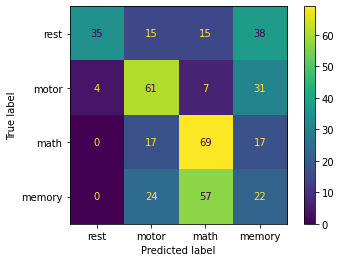

In [45]:
### MEG_Classifier_intra ###
## Define Parameters
data_source = [0,0,0]
data_offset = [0,30,700]
data_betweensample_offset = [170,170,170]
data_sample_size = 248
epochs=[25]#,10,25]
patience=[5,3,3]
model_name = 'MEG_Classifier_intra'

## Build Model
meg_classifier = ModelGenerator(model_name, (248, data_sample_size, 1))

## Train Model
history = train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset, 
                      data_betweensample_offset=data_betweensample_offset, data_sample_size = data_sample_size)
print(history)

## Test Model

ds_Gen2 = DatasetGenerator()
test_X, test_y = ds_Gen2.create_testDataSet(sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()

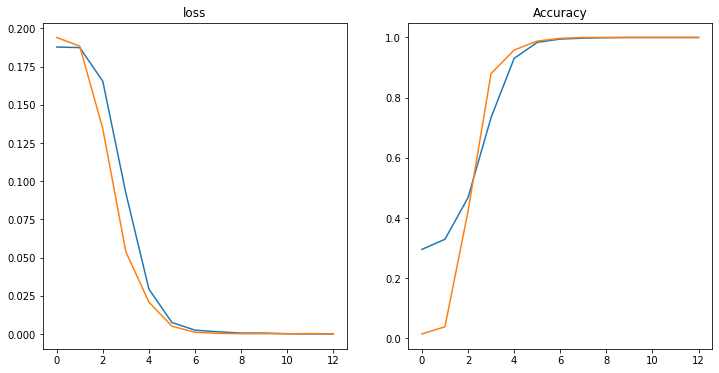

In [50]:
  fig, axs = plt.subplots(1,2,figsize=(12,6))

  axs[0].set_title('loss')
  axs[0].plot(history.history['loss'])
  axs[0].plot(history.history['val_loss'])
  axs[1].set_title('Accuracy')
  axs[1].plot(history.history['accuracy'])
  axs[1].plot(history.history['val_accuracy'])
  plt.show()

Start Cycle 0
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1672, 248, 248, 1)
Epoch 1/125
42/42 [==============================] - 2s 42ms/step - loss: 0.1739 - accuracy: 0.3797 - val_loss: 0.1402 - val_accuracy: 0.5060
Epoch 2/125
42/42 [==============================] - 1s 36ms/step - loss: 0.0840 - accuracy: 0.7429 - val_loss: 0.0477 - val_accuracy: 0.8802
Epoch 3/125
42/42 [==============================] - 1s 36ms/step - loss: 0.0172 - accuracy: 0.9641 - val_loss: 0.0152 - val_accuracy: 0.9611
Epoch 4/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0029 - accuracy: 0.9925 - val_loss: 0.0034 - val_accuracy: 0.9910
Epoch 5/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0028 - accuracy: 0.9940 - val_loss: 0.0014 - val_accuracy: 0.9970
Epoch 6/125
42/42 [==============================] - 1s 34ms/step - loss: 0.0019 - accuracy: 0.9955 - val_loss: 7.12

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)


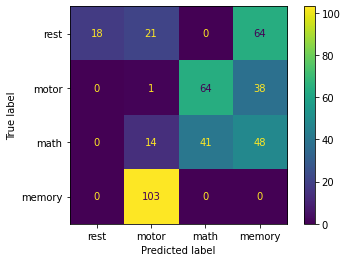

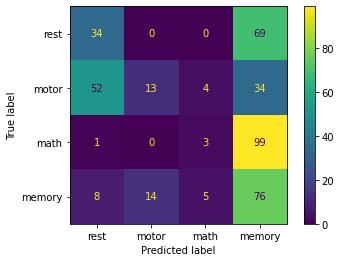

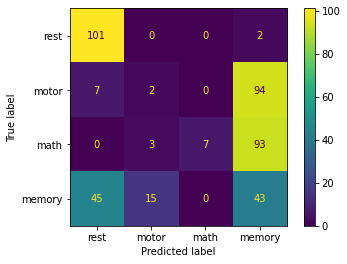

In [60]:
### MEG_Classifier_intra ###
## Define Parameters
data_source = [1,1,1]
data_offset = [0,30,70]
data_betweensample_offset = [170,170,170]
data_sample_size = 248
epochs=[125]#,25]#,25]
patience=[15,3,3]
model_name = 'MEG_Classifier_cross'

## Build Model
meg_classifier = ModelGenerator(model_name, (248, data_sample_size, 1))

## Train Model
history = train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset, 
                      data_betweensample_offset=data_betweensample_offset, data_sample_size = data_sample_size)
print(history)

## Test Model

ds_Gen2 = DatasetGenerator()
test_X, test_y = ds_Gen2.create_testDataSet(1,1,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()

test_X, test_y = ds_Gen2.create_testDataSet(1,2,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

test_X, test_y = ds_Gen2.create_testDataSet(1,3,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

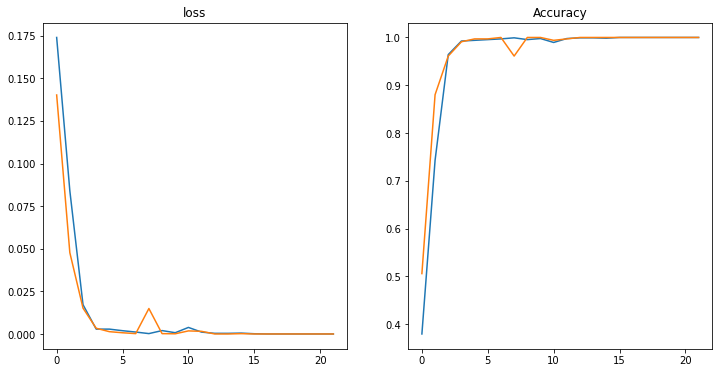

In [64]:
  fig, axs = plt.subplots(1,2,figsize=(12,6))

  axs[0].set_title('loss')
  axs[0].plot(history.history['loss'])
  axs[0].plot(history.history['val_loss'])
  axs[1].set_title('Accuracy')
  axs[1].plot(history.history['accuracy'])
  axs[1].plot(history.history['val_accuracy'])
  plt.show()

Start Cycle 0
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1672, 248, 248, 1)
Epoch 1/125
42/42 [==============================] - 2s 42ms/step - loss: 0.1655 - accuracy: 0.4155 - val_loss: 0.1325 - val_accuracy: 0.5689
Epoch 2/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0749 - accuracy: 0.7735 - val_loss: 0.0327 - val_accuracy: 0.9401
Epoch 3/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0177 - accuracy: 0.9686 - val_loss: 0.0516 - val_accuracy: 0.8802
Epoch 4/125
42/42 [==============================] - 2s 37ms/step - loss: 0.0138 - accuracy: 0.9716 - val_loss: 0.0062 - val_accuracy: 0.9880
Epoch 5/125
42/42 [==============================] - 1s 34ms/step - loss: 0.0075 - accuracy: 0.9806 - val_loss: 0.0074 - val_accuracy: 0.9820
Epoch 6/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0081 - accuracy: 0.9843 - val_loss: 0.00

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/25
42/42 [==============================] - 2s 38ms/step - loss: 0.0012 - accuracy: 0.9970 - val_loss: 1.8635e-04 - val_accuracy: 1.0000
Epoch 2/25
42/42 [==============================] - 2s 37ms/step - loss: 6.9018e-04 - accuracy: 0.9985 - val_loss: 1.7480e-05 - val_accuracy: 1.0000
Epoch 3/25
42/42 [==============================] - 1s 35ms/step - loss: 8.2610e-06 - accuracy: 1.0000 - val_loss: 4.7591e-06 - val_accuracy: 1.0000
Epoch 4/25
42/42 [==============================] - 1s 34ms/step - loss: 3.1059e-06 - accuracy: 1.0000 - val_loss: 1.9207e-07 - val_accuracy: 1.0000
Start Cycle 2
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/25
42/42 [==============================] - 2s 37ms/step - loss: 4.4372e-04 - accuracy: 0.9993 - val_loss: 0.0019 - val_accuracy: 0.9940
Epoch 2/25
42/42 [==============================] - 1s 33ms/step - loss: 3.7564e-04 - accuracy: 0.9993 - val_loss: 8.0622e-06 - val_accuracy: 1.0000
Epoch 3/25
42/42 [==============================] - 1s 35ms/step - loss: 8.6266e-06 - accuracy: 1.0000 - val_loss: 5.8734e-06 - val_accuracy: 1.0000
Epoch 4/25
42/42 [==============================] - 1s 34ms/step - loss: 3.2290e-06 - accuracy: 1.0000 - val_loss: 2.2167e-06 - val_accuracy: 1.0000
Epoch 5/25
42/42 [==============================] - 1s 36ms/step - loss: 2.2965e-06 - accuracy: 1.0000 - val_loss: 2.0854e-06 - val_accuracy: 1.0000
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)


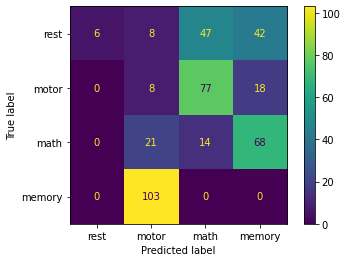

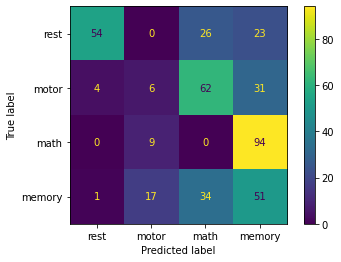

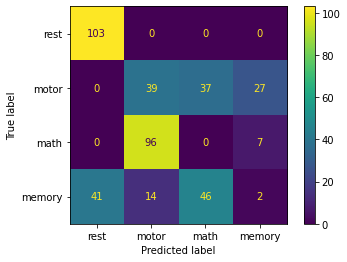

In [80]:
### MEG_Classifier_intra ###
## Define Parameters
data_source = [1,1,1]
data_offset = [0,170,10]
data_betweensample_offset = [340,340,170]
data_sample_size = 248
epochs=[125,25,25]
patience=[5,3,3]
model_name = 'MEG_Classifier_cross'

## Build Model
meg_classifier = ModelGenerator(model_name, (248, data_sample_size, 1),batch_norm = True)

## Train Model
history = train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset, 
                      data_betweensample_offset=data_betweensample_offset, data_sample_size = data_sample_size)
print(history)

## Test Model

ds_Gen2 = DatasetGenerator()
test_X, test_y = ds_Gen2.create_testDataSet(1,1,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()

test_X, test_y = ds_Gen2.create_testDataSet(1,2,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

test_X, test_y = ds_Gen2.create_testDataSet(1,3,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

In [ ]:
do_model('MEG_Classifier_intracross', epochs=[10,10,10,10,10], patience=[3,5,5,5,5], data_source = [0,0,0,1,1], data_offset = [0,60,120,0,90])

Start Cycle 0
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1672, 248, 248, 1)
Epoch 1/125
42/42 [==============================] - 2s 41ms/step - loss: 0.1783 - accuracy: 0.3333 - val_loss: 0.0977 - val_accuracy: 0.6826
Epoch 2/125
42/42 [==============================] - 1s 34ms/step - loss: 0.0803 - accuracy: 0.7720 - val_loss: 0.0182 - val_accuracy: 0.9551
Epoch 3/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0108 - accuracy: 0.9753 - val_loss: 0.0051 - val_accuracy: 0.9880
Epoch 4/125
42/42 [==============================] - 1s 36ms/step - loss: 0.0038 - accuracy: 0.9895 - val_loss: 0.0055 - val_accuracy: 0.9850
Epoch 5/125
42/42 [==============================] - 2s 37ms/step - loss: 0.0025 - accuracy: 0.9940 - val_loss: 1.1446e-04 - val_accuracy: 1.0000
Epoch 6/125
42/42 [==============================] - 1s 35ms/step - loss: 0.0030 - accuracy: 0.9925 - val_loss: 

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(832, 248, 248, 1)
Epoch 1/25
21/21 [==============================] - 1s 46ms/step - loss: 0.1167 - accuracy: 0.6682 - val_loss: 0.0353 - val_accuracy: 0.9337
Epoch 2/25
21/21 [==============================] - 1s 37ms/step - loss: 0.0151 - accuracy: 0.9670 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/25
21/21 [==============================] - 1s 34ms/step - loss: 0.0026 - accuracy: 0.9940 - val_loss: 0.0078 - val_accuracy: 0.9759
Epoch 4/25
21/21 [==============================] - 1s 34ms/step - loss: 0.0034 - accuracy: 0.9880 - val_loss: 3.9708e-04 - val_accuracy: 1.0000
Epoch 5/25
21/21 [==============================] - 1s 35ms/step - loss: 5.4832e-04 - accuracy: 0.9985 - val_loss: 5.8788e-05 - val_accuracy: 1.0000
Start Cycle 2
Create Train Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(1668, 248, 248, 1)
Epoch 1/25
42/42 [==============================] - 2s 40ms/step - loss: 0.0246 - accuracy: 0.9371 - val_loss: 0.0036 - val_accuracy: 0.9940
Epoch 2/25
42/42 [==============================] - 1s 35ms/step - loss: 0.0074 - accuracy: 0.9820 - val_loss: 0.0023 - val_accuracy: 0.9940
Epoch 3/25
42/42 [==============================] - 1s 34ms/step - loss: 0.0026 - accuracy: 0.9918 - val_loss: 0.0014 - val_accuracy: 0.9970
Epoch 4/25
42/42 [==============================] - 1s 35ms/step - loss: 0.0017 - accuracy: 0.9948 - val_loss: 0.0033 - val_accuracy: 0.9940
Epoch 5/25
42/42 [==============================] - 1s 35ms/step - loss: 5.9743e-04 - accuracy: 0.9985 - val_loss: 0.0012 - val_accuracy: 0.9970
Epoch 6/25
42/42 [==============================] - 1s 36ms/step - loss: 7.4875e-04 - accuracy: 0.9978 - val_loss: 4.

Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(204, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)
Create Test Dataset:


Block [rest]: - - - Finished
Block [task_motor]: - - - Finished
Block [task_story_math]: - - - Finished
Block [task_working_memory]: - - - Finished
Shape:(412, 248, 248, 1)


732

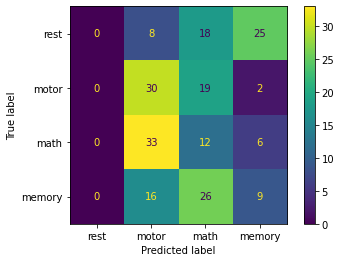

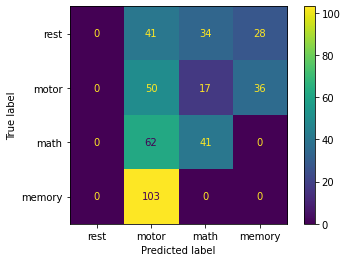

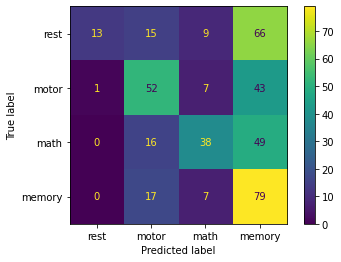

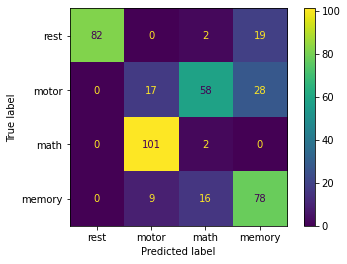

In [81]:
### MEG_Classifier_intra ###
## Define Parameters
data_source = [1,0,1]
data_offset = [0,0,70]
data_betweensample_offset = [170,170,170]
data_sample_size = 248
epochs=[125,25,25]
patience=[5,3,3]
model_name = 'MEG_Classifier_cross'

## Build Model
meg_classifier = ModelGenerator(model_name, (248, data_sample_size, 1),batch_norm = True)

## Train Model
history = train_model(meg_classifier,epochs=epochs, patience=patience, data_source = data_source, data_offset = data_offset, 
                      data_betweensample_offset=data_betweensample_offset, data_sample_size = data_sample_size)
print(history)

## Test Model

ds_Gen2 = DatasetGenerator()

test_X, test_y = ds_Gen2.create_testDataSet(sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()

test_X, test_y = ds_Gen2.create_testDataSet(1,1,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()

test_X, test_y = ds_Gen2.create_testDataSet(1,2,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()

test_X, test_y = ds_Gen2.create_testDataSet(1,3,sample_window = [170,data_sample_size,0])

all_classes = ["rest", "motor", "math", "memory"]
cm = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(meg_classifier.model.predict(test_X),axis=1))
disp = ConfusionMatrixDisplay(cm,display_labels=all_classes)  
disp.plot()

gc.collect()